In [1]:
import torch
import matplotlib.pyplot as plt

from escnn import group, gspaces

import sys

sys.path.append("..")

from models.core.implicit_kernel import ImplicitKernel
from models.core.kernel_utils import generate_kernel_grid

# G-steerable implicit kernels

In this demo, we will demonstrate how to initialize and use implicit steerable kernels. We will consider two cases:
- G = O(2) on $\mathbb{R}^2$, for which an analytically derived basis is available;
- G = SO(2) on $\mathbb{R}^3$, for which there is no known analytical basis.

For the first scenario, we will also compare how our learned basis corresponds to the analytically derived basis and see if they coincide.

## G = O(2) on $\mathbb{R}^2$

Let us start with a group, for which an analytical solution is known. 
Since we work in escnn, we need to specify the group + the space it acts on.
The input space is $\mathbb{R}^2$ with O(2) group on it.

In [2]:
gspace = gspaces.flipRot2dOnR2()

Let us now define the input data as a field that consists of scalar, vector and pseudoscalar components. 

In [3]:
scalar_repr, pseudoscalar_repr, vector_repr = gspace.fibergroup.irreps()[:3]
channel_repr = group.directsum([scalar_repr, vector_repr, pseudoscalar_repr])

For visualization, we set the number of input and output channels to 1.
Hence, each representation will contain only one copy of the field representation.

In [4]:
c_in = 1
c_out = 1

conv_in_repr = c_in * [channel_repr]
conv_out_repr = c_out * [channel_repr]

In [5]:
conv_in_type = gspace.type(*conv_in_repr)
conv_out_type = gspace.type(*conv_out_repr)

Now we are ready to define a O(2)-steerable kernel.

In [6]:
kernel = ImplicitKernel(
    conv_in_type=conv_in_type,
    conv_out_type=conv_out_type,
    kernel_attr_type=None,
    n_layers=2,
    n_channels=16,
)

for visualization purposes, let's sample the kernel on a regular grid.

In [7]:
resolution = 121  # 121 points for each dimension
edge_delta = generate_kernel_grid(kernel_size=resolution, dim=gspace.dimensionality)

k = kernel(edge_delta)

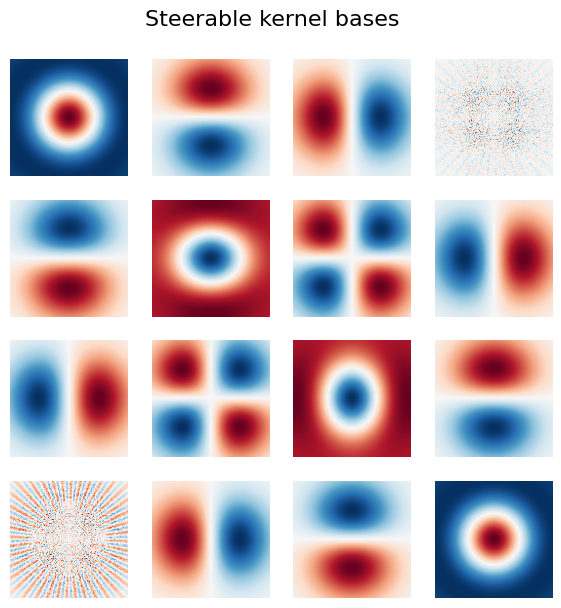

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(7, 7))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            k[:, i, j].detach().numpy().reshape(*[resolution] * 2), cmap="RdBu"
        )
        ax[i, j].axis("off")

fig.suptitle("Steerable kernel bases", fontsize=16, y=0.95)
plt.show()

The learned basis above corresponds to the analytically derived basis (see https://arxiv.org/abs/2402.14730, Appendix B for source), where R denotes a radial part. The only difference is that in our solution there are non-zero kernels for $1$ to $e_{12}$ components. Those come, however, from numerical artefacts in non-linearities and have magniture of $10^{-6}$, which is negligible.
    
![O(2) kernel bases](../assets/O2_bases.png)

# G = SO(2) on $\mathbb{R}^3$

Let's now generate kernels for which there are no analytical solutions. For example, azymuthal rotation (rotation around the z-axis) in 3D.
The code is constructed such that it assumes the full orthogonal group O(n), and user specifies the subgroup id of $G \leq O(n)$. 
See https://quva-lab.github.io/escnn/api/escnn.group.html for details about subgroup structure and values of subgroup id.

In [9]:
gspace = gspaces.flipRot3dOnR3()

We will use the same structure of feature fields as in the previous example: scalar, vector and pseudoscalar channels.

In [10]:
scalar_repr = gspace.trivial_repr
vector_repr = gspace.fibergroup.standard_representation()
channel_repr = group.directsum([scalar_repr, vector_repr])

Let us also assume that there features on edges that we want to use to condition the kernel.
We assume that those features are scalars and hence have trivial representation.

In [16]:
c_in = 1
c_out = 1
c_edge = 1

conv_in_repr = c_in * [channel_repr]
conv_out_repr = c_out * [channel_repr]

edge_attr_repr = c_edge * [gspace.trivial_repr]  # equal to scalar_repr

### Restriction to the subgroup

So far, we defined our representations for the O(3) group, but we want to work with its subgroup. 

Quick inspection (https://quva-lab.github.io/escnn/api/escnn.group.html#escnn.group.O3) of the escnn documentation says that subgroup id for SO(2) is (False, False, -1).

In [17]:
subgroup_id = (False, False, -1)

Now we restrict every representation to the required subgroup.

In [18]:
conv_in_type = gspace.type(*conv_in_repr).restrict(subgroup_id)
conv_out_type = gspace.type(*conv_out_repr).restrict(subgroup_id)
edge_attr_type = gspace.type(*edge_attr_repr).restrict(subgroup_id)

### Kernel definition

Let's define the kernel:

In [19]:
kernel = ImplicitKernel(
    conv_in_type=conv_in_type,
    conv_out_type=conv_out_type,
    kernel_attr_type=edge_attr_type,
    n_layers=8,
    n_channels=16,
)

We evaluate the kernel on a regular grid and use distances as edge attributes.

In [20]:
resolution = 32  # 121 points for each dimension
edge_delta = generate_kernel_grid(kernel_size=resolution, dim=gspace.dimensionality)
edge_attr = torch.norm(edge_delta, dim=-1, keepdim=True)

k = kernel(edge_delta, edge_attr)

Let's now take 2 slices of the kernel tensor and visualize it.
We expect to see the following pattern:

- for the slice in xy plane, we expect to see the standard SO(2)-steerable kernel basis.
- for the slice in any other plane, the symmetry should be broken, and the kernels will not look symmetric.

In [21]:
k = k.reshape(resolution, resolution, resolution, k.shape[-2], k.shape[-1])

In [22]:
k_x_slice = k[resolution // 2, :, :]
k_z_slice = k[:, :, resolution // 2]

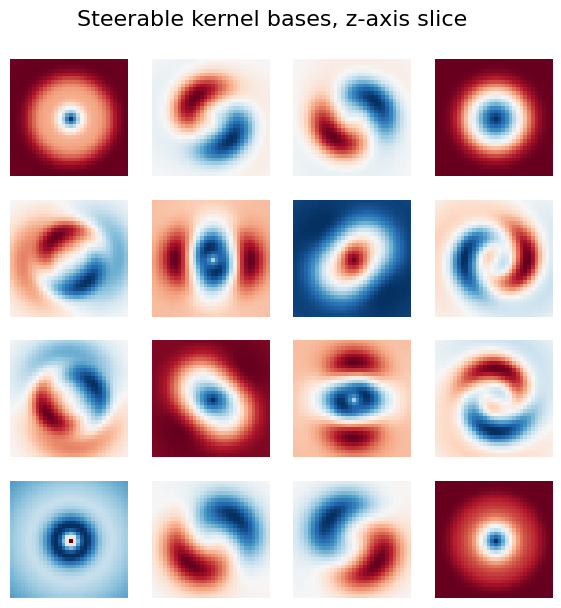

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(7, 7))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            k_z_slice[:, :, i, j].detach().numpy().reshape(*[resolution] * 2),
            cmap="RdBu",
        )
        ax[i, j].axis("off")

fig.suptitle("Steerable kernel bases, z-axis slice", fontsize=16, y=0.95)
plt.show()

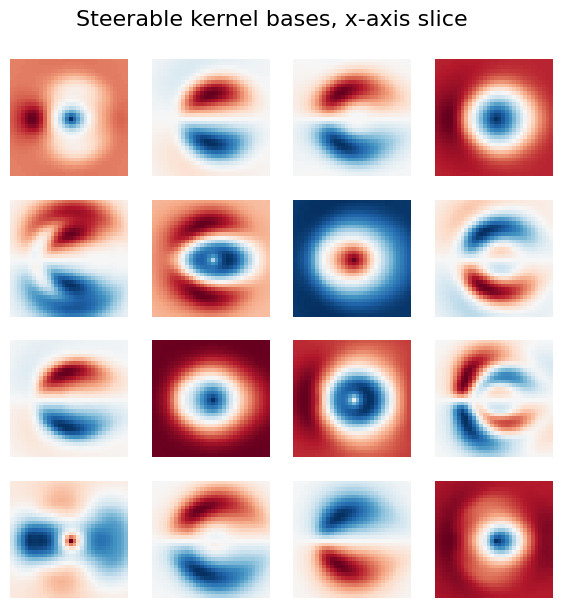

In [24]:
fig, ax = plt.subplots(4, 4, figsize=(7, 7))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            k_x_slice[:, :, i, j].detach().numpy().reshape(*[resolution] * 2),
            cmap="RdBu",
        )
        ax[i, j].axis("off")

fig.suptitle("Steerable kernel bases, x-axis slice", fontsize=16, y=0.95)
plt.show()